In [1]:
!pip install pycaret==3.3.1

In [2]:
!pip install scikit-optimize==0.9.0

In [3]:
from google.colab import files
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from pycaret.regression import *
from skopt import BayesSearchCV

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


- **나이**: 주요 수혜자의 나이

- **성별**: 보험 계약자 성별, 여성, 남성

- **bmi**: 신체질량지수, 키에 비해 상대적으로 높거나 낮은 체중을 파악하는 지표,
키와 체중의 비율을 이용한 객관적인 체중지수(kg/m^2), 이상적으로는 18.5~24.9

- **자녀**: 건강보험 적용 자녀 수 / 부양가족 수

- **흡연자**: 흡연

- **지역**: 미국 내 수혜자의 거주 지역, 북동부, 남동부, 남서부, 북서부.

- **요금**: 건강 보험에서 청구하는 개인 의료비

In [4]:
uploaded = files.upload()

Saving insurance.csv to insurance (1).csv


In [5]:
df = pd.read_csv('insurance.csv')
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [6]:
# 결측치가 없음을 확인 함.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


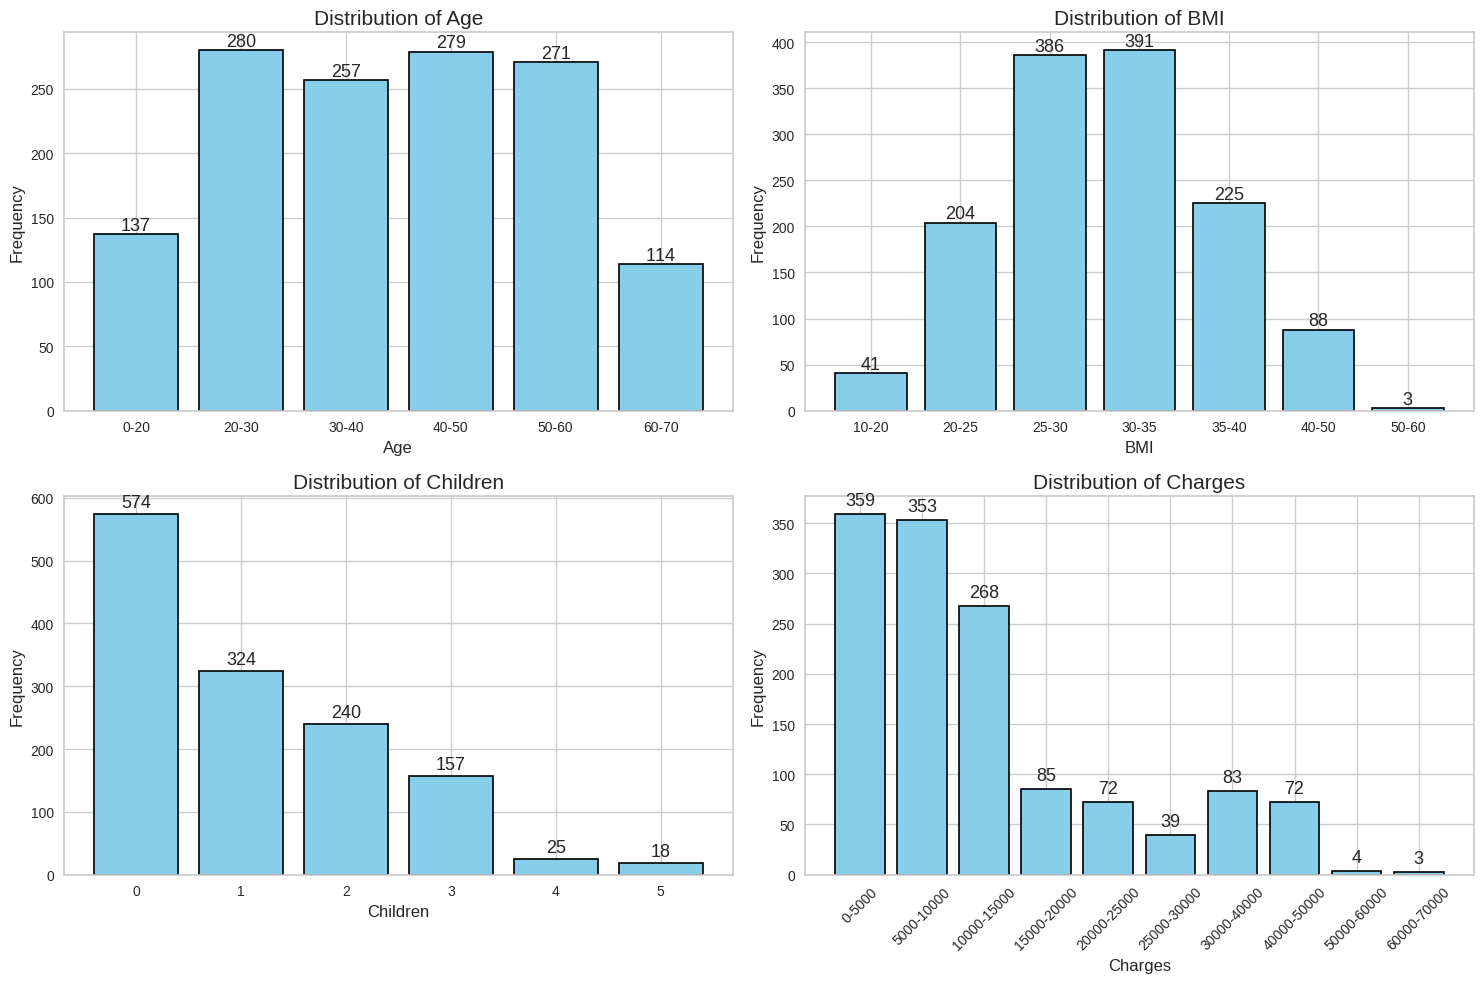

In [7]:
# 서브플롯 생성
plt.figure(figsize=(15, 10))

# 첫 번째 서브플롯 (나이(age) 분포)
plt.subplot(2, 2, 1)
age_bins = [0, 20, 30, 40, 50, 60, 70]
age_labels = ['0-20', '20-30', '30-40', '40-50', '50-60', '60-70']
age_bins = pd.cut(df['age'], bins=age_bins, labels=age_labels, right=False)
age_counts = age_bins.value_counts().sort_index()
bars_age = plt.bar(age_counts.index, age_counts.values, color='skyblue', edgecolor='black', linewidth=1.2)
for bar in bars_age:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.2, yval, ha='center', va='bottom', fontsize=13)
plt.xlabel('Age', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Age', fontsize=15)
plt.xticks(fontsize=10)

# 두 번째 서브플롯 (BMI 분포)
plt.subplot(2, 2, 2)
bmi_bins = [10, 20, 25, 30, 35, 40, 50, 60]
bmi_labels = ['10-20', '20-25', '25-30', '30-35', '35-40', '40-50', '50-60']
bmi_bins = pd.cut(df['bmi'], bins=bmi_bins, labels=bmi_labels, right=False)
bmi_counts = bmi_bins.value_counts().sort_index()
bars_bmi = plt.bar(bmi_counts.index, bmi_counts.values, color='skyblue', edgecolor='black', linewidth=1.2)
for bar in bars_bmi:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.2, yval, ha='center', va='bottom', fontsize=13)
plt.xlabel('BMI', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of BMI', fontsize=15)
plt.xticks(fontsize=10)

# 세 번째 서브플롯 (Children 분포)
plt.subplot(2, 2, 3)
children_bins = [-0.5, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5]  # 각 카테고리의 경계 설정
children_labels = ['0', '1', '2', '3', '4', '5']  # 각 카테고리의 레이블
children_counts = df['children'].value_counts().sort_index()
bars_children = plt.bar(children_labels, children_counts.values, color='skyblue', edgecolor='black', linewidth=1.2)
for bar in bars_children:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 5, yval, ha='center', va='bottom', fontsize=13)
plt.xlabel('Children', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Children', fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# 네 번째 서브플롯 (Charges 분포)
plt.subplot(2, 2, 4)
charge_bins = [0, 5000, 10000, 15000, 20000, 25000, 30000, 40000, 50000, 60000, 70000]
charge_labels = ['0-5000', '5000-10000', '10000-15000', '15000-20000', '20000-25000', '25000-30000', '30000-40000', '40000-50000', '50000-60000', '60000-70000']
charge_bins = pd.cut(df['charges'], bins=charge_bins, labels=charge_labels, right=False)
charge_counts = charge_bins.value_counts().sort_index()
bars_charges = plt.bar(charge_counts.index, charge_counts.values, color='skyblue', edgecolor='black', linewidth=1.2)
for bar in bars_charges:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 5, yval, ha='center', va='bottom', fontsize=13)
plt.xlabel('Charges', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Charges', fontsize=15)
plt.xticks(fontsize=10, rotation=45)

plt.tight_layout()
plt.show()

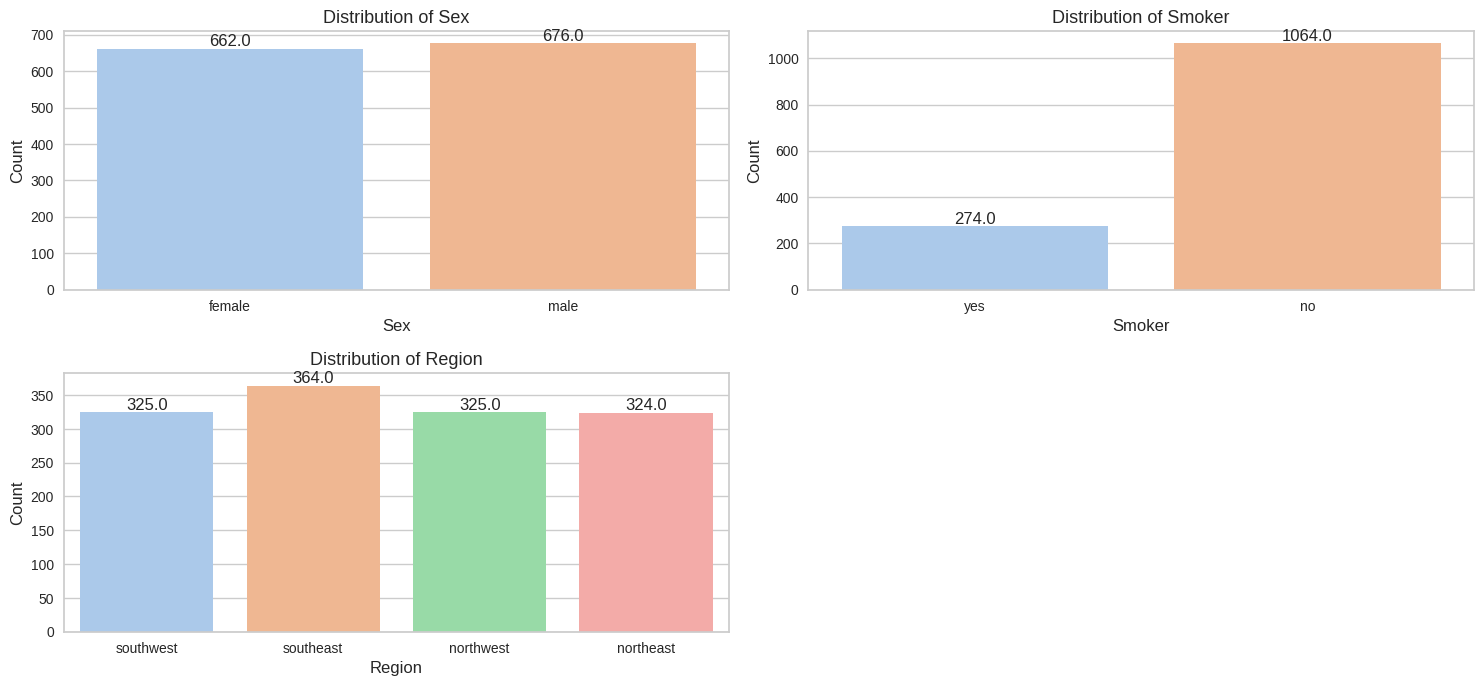

In [8]:
# 카운트 플롯을 이용한 범주형 데이터 시각화
plt.figure(figsize=(15, 10))

# Sex
plt.subplot(3, 2, 1)
sns.countplot(x=df['sex'], palette='pastel')
plt.xlabel('Sex', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Distribution of Sex', fontsize=13)
# 각 막대 위에 수치 표시
for p in plt.gca().patches:
    plt.gca().annotate(f"{p.get_height()}", (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha='center', va='center', xytext=(0, 5), textcoords='offset points', fontsize=12)

# Smoker
plt.subplot(3, 2, 2)
sns.countplot(x=df['smoker'], palette='pastel')
plt.xlabel('Smoker', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Distribution of Smoker', fontsize=13)
# 각 막대 위에 수치 표시
for p in plt.gca().patches:
    plt.gca().annotate(f"{p.get_height()}", (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha='center', va='center', xytext=(0, 5), textcoords='offset points', fontsize=12)

# Region
plt.subplot(3, 2, 3)
sns.countplot(x=df['region'], palette='pastel')
plt.xlabel('Region', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Distribution of Region', fontsize=13)
# 각 막대 위에 수치 표시
for p in plt.gca().patches:
    plt.gca().annotate(f"{p.get_height()}", (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha='center', va='center', xytext=(0, 5), textcoords='offset points', fontsize=12)

plt.tight_layout()
plt.show()

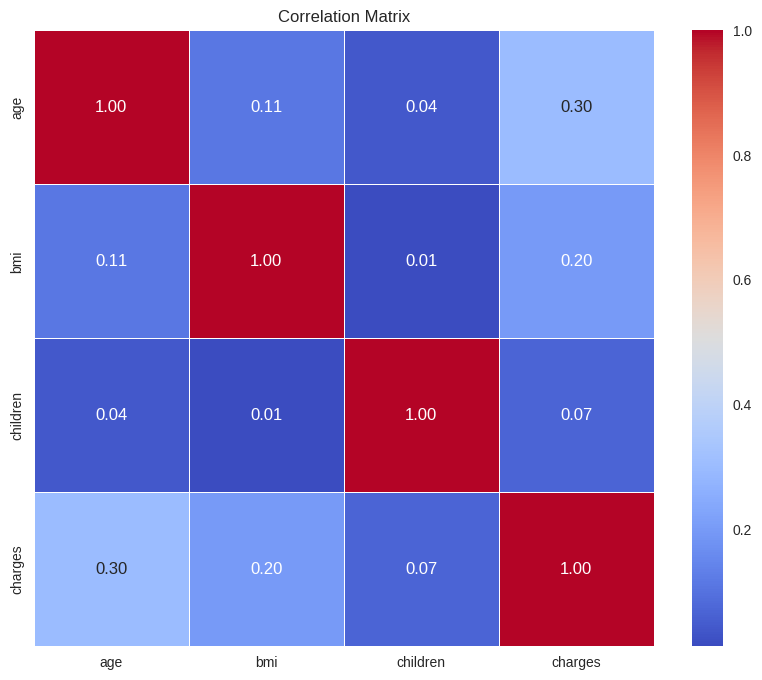

In [9]:
plt.figure(figsize=(10, 8))
corr = df.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In [10]:
# PyCaret의 setup 함수 사용하여 머신 러닝 모델을 학습하기 위한 형태로 변환
model = setup(data=df,
              target='charges',
              categorical_features=['sex', 'smoker', 'region'],
              normalize=True, normalize_method='minmax',
              train_size=0.8,
              session_id=42) # Random seed

,Description,Value
0,Session id,42
1,Target,charges
2,Target type,Regression
3,Original data shape,"(1338, 7)"
4,Transformed data shape,"(1338, 10)"
5,Transformed train set shape,"(1070, 10)"
6,Transformed test set shape,"(268, 10)"
7,Numeric features,3
8,Categorical features,3
9,Preprocess,True


In [11]:
# 모델의 설명력을 평가하고, 그 성능을 비교하기 위한 목적에서
# 좀 더 직관적이고 일반적으로 사용되는 지표를 활용하기 위해서 R2 지표도 확인해보기.
top_3_models = compare_models(sort='RMSE', n_select = 3)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,2609.8744,21714023.9797,4624.2374,0.8444,0.4325,0.3031,0.0620
lightgbm,Light Gradient Boosting Machine,2943.6636,24416570.6599,4910.8092,0.8248,0.5236,0.3583,97.3950
rf,Random Forest Regressor,2825.1307,24838293.4569,4959.9233,0.8230,0.4640,0.3314,0.1140
ada,AdaBoost Regressor,3981.0569,26747817.8312,5156.3222,0.8104,0.5917,0.6510,0.0340
et,Extra Trees Regressor,2768.2531,27165447.1879,5192.9926,0.8057,0.4720,0.3153,0.0970
xgboost,Extreme Gradient Boosting,3250.5256,30095093.6000,5467.6827,0.7873,0.6067,0.4278,0.0480
knn,K Neighbors Regressor,3649.9163,35550660.4000,5934.6120,0.7469,0.4883,0.3600,0.0310
lasso,Lasso Regression,4242.3928,37881920.2778,6132.7752,0.7298,0.5870,0.4237,0.0250
llar,Lasso Least Angle Regression,4242.3837,37882017.1413,6132.7813,0.7298,0.5870,0.4237,0.0250
lar,Least Angle Regression,4243.9235,37885866.4059,6133.0840,0.7297,0.5877,0.4241,0.0260


Processing:   0%|          | 0/83 [00:00<?, ?it/s]

In [12]:
for i, model in enumerate(top_3_models):
    filename = f'top_model_{i+1}'
    save_model(model, filename)
    files.download(filename + '.pkl')

Transformation Pipeline and Model Successfully Saved


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Transformation Pipeline and Model Successfully Saved


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Transformation Pipeline and Model Successfully Saved


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [13]:
top_3_models = [load_model(f'top_model_{i}') for i in range(1, 4)]

Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
